In [47]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by elastic net 

Before a lasso regression was applied, but lead to not profound set of predictors, each model run lead to a nearly complete new selection of feautres. Therefore and in regard to strong multicollinearity (see pearson Correlation plot) a Elastic Net is tested.

Elastic Net combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model’s predictions.

*Sources*
Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392

In [57]:
import numpy as np
import pandas as pd

import pickle

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, cross_validate
from sklearn.compose import TransformedTargetRegressor

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

from utils_feature_selection import save_selected_features



seed = np.random.seed(1112)

import warnings
warnings.filterwarnings('ignore')



In [49]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_business.xlsx")
print(df_candidates.shape)
df_candidates.tail(2)


(397, 61)


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,...,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,shp_content_value_euro,shp_registered_capital_euro,elevation_m
395,0.0,NaN,4.0,70.0,0,1,0,0,1,1,...,5,1.0,2.0,2.0,NaN,1.0,3.0,NaN,11047.7,1.83886
396,0.0,0.0,3.0,100.0,0,1,0,0,1,1,...,5,NaN,3.0,2.0,NaN,NaN,3.0,NaN,736.5,1.87277


## Clean dataset from features and records with too many missing values


In [50]:
print("Percentage of missing valeus per feature\n", df_candidates.isna().mean().sort_values(ascending=False)[:15] ) 

Percentage of missing valeus per feature
 warning_time_h                                 0.775819
perception_who_responsible4protection.Rank2    0.392947
perception_govern_support_past                 0.382872
perception_govern_support_future               0.342569
elevation_building_height_cm                   0.158690
shp_content_value_euro                         0.156171
resilience_govern_careing_increases            0.136020
shp_registered_capital_euro                    0.118388
Target_businessreduction                       0.090680
perception_who_responsible4protection.Rank1    0.070529
shp_risk_tolerance                             0.070529
bage                                           0.068010
perception_private_economy_future              0.065491
hh_monthly_income_cat                          0.060453
resilience_govern_careing                      0.057935
dtype: float64


In [51]:
## delete features with more than 10% missing values
# print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))
df_candidates = df_candidates[df_candidates.columns[df_candidates.isna().mean() < 0.10]]  # drop feautres with more than 10% missing values
print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))

## --> drop content values if threshold == 15%

Target_businessreduction                       36
perception_who_responsible4protection.Rank1    28
shp_risk_tolerance                             28
bage                                           27
perception_private_economy_future              26
hh_monthly_income_cat                          24
resilience_govern_careing                      23
resilience_govern_warnings_helpful             18
shp_monetary_resources4prevention              18
resilience_more_future_affected                15
resilience_city_protection                     15
shp_profits_last5years                         15
Target_contentloss_euro                        11
resilience_neighbor_management                 11
inundation_duration_h                           9
elevation_m                                     4
b_area                                          2
water_depth_cm                                  1
emergency_measures.8                            0
emergency_measures.1                            0


In [52]:
print(df_candidates.isna().sum().sort_values(ascending=False)) # remaining abs number of nan per feature

Target_businessreduction                       36
perception_who_responsible4protection.Rank1    28
shp_risk_tolerance                             28
bage                                           27
perception_private_economy_future              26
hh_monthly_income_cat                          24
resilience_govern_careing                      23
resilience_govern_warnings_helpful             18
shp_monetary_resources4prevention              18
resilience_more_future_affected                15
resilience_city_protection                     15
shp_profits_last5years                         15
Target_contentloss_euro                        11
resilience_neighbor_management                 11
inundation_duration_h                           9
elevation_m                                     4
b_area                                          2
water_depth_cm                                  1
emergency_measures.8                            0
emergency_measures.1                            0


In [53]:
# ## TODO fix missing values by filling or removing them:
# ## Idea: remove nan in targets (->get 2 ds) and fill missing values in candidate predictors
# ## or think about to remove predictors with very many missing values , even they are significant correlated to target eg. warning time

## number of missing values for each predictor and for each case
# df_candidates_t.isna().sum().sort_values(ascending=False)
#t = df_candidates_t.drop(["perception_govern_support_future", "warning_time_h"], axis=1)
# t.isna().sum().sum()

# df_candidates.isna().sum(axis=1).sort_values(ascending=False) # nan per case


#### Hyperparamters to test

In [54]:
## Hyperparameter ranges to test

param_grid = {
    "name__estimator__alpha": [0.001, 0.01, 0.1, 1, 5],      # alpha: constant mulitplies penality term, alpha = 0 is equivalent to an OLS solved by the LinearRegression
    "name__estimator__max_iter": [1,2,3,4],
    "name__estimator__l1_ratio": np.arange(0.0, 1.0, 0.25),     # r = 0, equivalent to Ridge Regression (=L2),  r = 1 equivalent to Lasso Regression (=L1) 
    "name__estimator__tol": [0.5],
    "name__estimator__random_state": [seed],
}

param_bagging = {
    'bootstrap': [True, False],
    'random_state': [seed]
    # 'bootstrap_features': [True, False],
    # 'n_estimators': [20,50,100],
    # 'max_samples': [0.5,1.0, X_train.shape[0]//2,],
    # 'max_features': [0.5,1.0, X_train.shape[1]//2,],
    # oob_score
}
## TODO add hyperparams for Bagging: 
## current defaults: n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False


In [55]:
BaggingRegressor.__init__	

<function sklearn.ensemble._bagging.BaggingRegressor.__init__(self, estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0, base_estimator='deprecated')>

In [56]:
df_candidates.Target_contentloss_euro[df_candidates.Target_contentloss_euro==0].count()

226

## Fit model and select features

In [76]:
# pipeline = Pipeline(steps=[('power', MinMaxScaler())])#), ('model', HuberRegressor())])
# # prepare the model with target scaling
# model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
# model

In [75]:
## iterate over both targets and store results 

targets = ["Target_contentloss_euro", "Target_businessreduction"]
importances_threshold = {"Target_contentloss_euro": 0.000, "Target_businessreduction": 0.000 }

for target in targets:

    print( f"\nApply Elastic Net on {target}:")

    df_candidates_t = df_candidates

   
    ## clean df from remaining records containg nan
    df_candidates_t = df_candidates_t.dropna()
    #df_candidates_t = df_candidates_t[df_candidates_t[target]!=0.0]

    print("Amount of missing target values should be zero: ", df_candidates_t[target].isna().sum())
    print("Uses ", df_candidates_t.shape[0], " records, from those have ", 
          { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, f" records zero {target.split('_')[1]}")

        
    X_unscaled = df_candidates_t.drop(targets, axis=1)  # remove bth targets from X
    y = df_candidates_t[target]
 
    ## test train split
    X_train, X_test, y_train, y_test = train_test_split(
        X_unscaled, y, test_size=0.25, 
        random_state=seed, shuffle=True
    )
    
    ## normalize X data 
    scaler_for_X = MinMaxScaler().fit(X_train)
    X_train = scaler_for_X.transform(pd.DataFrame(X_train))
    X_test = scaler_for_X.transform(pd.DataFrame(X_test))

    ## normalize y data 
    ## TODO find and test a better way to scale y, eg via TransformedTargetRegressor() ?
    y_train =np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    scaler_for_y = MinMaxScaler().fit(y_train)
    y_train = scaler_for_y.transform(pd.DataFrame(y_train))
    y_test = scaler_for_y.transform(pd.DataFrame(y_test))


    ## normalize y data and define already regressor model
    # use () to automatically manage the transformatition and inverse transform (back to original space)
    # prepare the model with input scaling
    # pipeline = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', ElasticNet())])
    # # prepare the model with target scaling
    # model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
    
    model = {'model': BaggingRegressor,   # default bootstrap=True
        'kwargs': {'estimator': ElasticNet()},  # TODO: pass 'random_state':seed to baggingregressor
        'parameters': param_grid,
        }
    pipeline = Pipeline( [('name', model['model'] (**model['kwargs']) ) ]  )  # pipeline for Bagging method
       # --> access params in pipline via <estimator>__<parameter> syntax , eg hyperParams for ElasticNet have to start with "name__estimator__<HyperParamName>""

    ## GridSearchCV to find best hyperparameters
    # alterniatve built-in version: ElasticNetCV()  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)  # =kfold=10, # cv method TODO find better method maybe RepeatedStratifiedKFold
    elastic_net_cv = GridSearchCV(
        pipeline, param_grid=model['parameters'], 
        cv=cv, scoring="neg_mean_absolute_error", 
        )

    ## Fit model 
    elastic_net_cv.fit(X_train, y_train)   # FIXME check if train-test split before or after feature selection 
    print(f"Best hyperparams: {elastic_net_cv.best_params_}")
    print('Train R^2 Score : %.3f'%elastic_net_cv.best_estimator_.score(X_train, y_train))
    print("CV score: ", elastic_net_cv.best_score_ ,  elastic_net_cv.best_estimator_.score(X_train, y_train),  elastic_net_cv.best_estimator_.score(X_test, y_test))
    ## score = coefficient of determination R2 which is (1 - (u/v)); 
    ## u= is the residual sum of squares ((y_true - y_pred)** 2).sum() and 
    ## v= is the total sum of squares ((y_true - y_true.mean()) ** 2).sum()
    ## --> r2: variance explained by model / total variance --> higher r2= better fitted model

    ## fit model again with best hyperparams
    print("Create new Elastic Net model based on best hyperparameters")
    elastic_net = ElasticNet(alpha = elastic_net_cv.best_params_['name__estimator__alpha'], 
                        max_iter = elastic_net_cv.best_params_['name__estimator__max_iter'],
                        l1_ratio = elastic_net_cv.best_params_['name__estimator__l1_ratio'],
                        tol = elastic_net_cv.best_params_['name__estimator__tol'],
                        #random_state=seed
                        )
    elastic_net.fit(X_train, y_train)
    
    ## store trained model for evaluation
    filename = f'./models_trained/elasticnet_{target}.sav'
    pickle.dump(elastic_net, open(filename, 'wb'))
    
    ## predict unseen data
    y_pred = elastic_net.predict(X_test)

    print(f"Best hyperparams: {elastic_net_cv.best_params_}")
    print('Train R^2 Score : %.3f'%elastic_net.score(X_train, y_train)) # how well did the model on the training set
    print('Test R^2 Score : %.3f'%elastic_net.score(X_test, y_test)) # .. compared to the unseen test set for overfitting 
    #print("MAE of best model: %.3f" % elastic_net_cv.best_score_)  # TODO check why MAE nan 
    rmse = np.square(np.subtract(y_test, y_pred)).mean()#np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE:  {:.2f}".format(rmse), "euros or in %") 

   ## Evaluate model

    ## get signifcant features based on absolute coeff values
    print("\nSelect features based on absoulte coefficient values")

    ## select significant features by using elstic net coefs (= linear relationship between features ~ target, adjusted by the regularization terms)
    df_importance = pd.DataFrame({
        "importances" : np.abs(elastic_net.coef_), # larger absolute coef value == more important feature
        }, index= X_unscaled.columns.to_list())
    df_importance = df_importance.loc[df_importance.importances > importances_threshold[target], : ].T      # drop features which dont reduce the loss

    ## write selected predictors and response to disk
    X_train = pd.DataFrame(X_train)
    X_train.columns = X_unscaled.columns
    y_train = pd.DataFrame(y_train)
    y_train.columns = [target]
    save_selected_features(X_train, y_train, df_importance.columns, filename=f"../../input_survey_data/fs_elasticnet_{target.split('_')[1]}.xlsx")


    ## evaluate
    # scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1) # neg_mean_absolute_error
    # print(scores)
    # # force scores to be positive
    # #scores = np.abs(scores)
    # #print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



Apply Elastic Net on Target_contentloss_euro:
Amount of missing target values should be zero:  0
Uses  220  records, from those have  {127}  records zero contentloss
Best hyperparams: {'name__estimator__alpha': 0.1, 'name__estimator__l1_ratio': 0.25, 'name__estimator__max_iter': 1, 'name__estimator__random_state': None, 'name__estimator__tol': 0.5}
Train R^2 Score : -0.002
CV score:  -0.0184759066669797 -0.001617140246626736 -0.021513133088314484
Create new Elastic Net model based on best hyperparameters
Best hyperparams: {'name__estimator__alpha': 0.1, 'name__estimator__l1_ratio': 0.25, 'name__estimator__max_iter': 1, 'name__estimator__random_state': None, 'name__estimator__tol': 0.5}
Train R^2 Score : 0.000
Test R^2 Score : -0.022
RMSE:  1.51 euros or in %

Select features based on absoulte coefficient values
selected features: 0
dropped features: 51
selected features: 
[]

Saving model to disk: ../../input_survey_data/fs_elasticnet_contentloss.xlsx

Apply Elastic Net on Target_busi

In [84]:
#scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#pd.DataFrame(scores).set_index("test_score").sort_index().T

# #Snippet from: https://ubc-cs.github.io/cpsc330/lectures/08_hyperparameter-optimization.html#exhaustive-grid-search-sklearn-model-selection-gridsearchcv
#pd.DataFrame(elastic_net_cv.cv_results_).set_index("rank_test_score").sort_index().T
pd.DataFrame(elastic_net_cv.cv_results_)[
        [                                   # only important cv evaluation metrics 
            "mean_test_score",
            "mean_fit_time",
            "rank_test_score",
            "param_name__estimator__alpha",
            "param_name__estimator__l1_ratio",
            "param_name__estimator__max_iter"
        ]
    ].set_index("rank_test_score").sort_index().T


rank_test_score,1,2,3,4,5,6,7,8,9,10,...,71,72,73,74,75,76,77,78,79,80
mean_test_score,-0.161909,-0.162379,-0.162852,-0.163181,-0.163294,-0.163337,-0.163358,-0.16421,-0.16422,-0.164316,...,-0.18661,-0.186612,-0.186612,-0.186714,-0.186795,-0.186815,-0.186838,-0.186881,-0.186984,-0.187086
mean_fit_time,0.037115,0.034241,0.032571,0.036024,0.030635,0.06564,0.02899,0.030611,0.032028,0.0311,...,0.030253,0.030979,0.034469,0.028573,0.054464,0.033672,0.028929,0.031192,0.028633,0.030357
param_name__estimator__alpha,0.1,0.01,0.1,0.01,0.1,0.1,0.01,0.01,0.01,0.01,...,5,5,5,1,5,1,1,1,1,0.1
param_name__estimator__l1_ratio,0.0,0.25,0.0,0.25,0.0,0.0,0.25,0.5,0.25,0.5,...,0.75,0.5,0.5,0.5,0.25,0.5,0.25,0.5,0.25,0.5
param_name__estimator__max_iter,3,1,1,2,2,4,4,1,3,2,...,4,4,2,3,2,1,4,2,2,1


In [25]:
pd.DataFrame(elastic_net_cv.cv_results_).set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,71,72,73,74,75,76,77,78,79,80
mean_fit_time,0.026069,0.031997,0.038316,0.027434,0.026066,0.04969,0.026136,0.03097,0.027737,0.035866,...,0.025537,0.029258,0.035756,0.03113,0.027799,0.028398,0.027401,0.02629,0.027001,0.026553
std_fit_time,0.001952,0.008702,0.010435,0.003079,0.002083,0.021245,0.001582,0.003223,0.003506,0.01437,...,0.001414,0.005511,0.014681,0.005988,0.003954,0.004614,0.003029,0.002377,0.002965,0.001816
mean_score_time,0.002398,0.004272,0.003733,0.002069,0.002064,0.004038,0.002199,0.002532,0.002066,0.003155,...,0.001998,0.002263,0.003358,0.002067,0.0024,0.002867,0.002467,0.0022,0.002601,0.002475
std_score_time,0.000711,0.003074,0.003283,0.00025,0.00057,0.003675,0.000394,0.000886,0.000575,0.001862,...,0.00036,0.000574,0.002004,0.000683,0.0008,0.00109,0.001147,0.000748,0.000713,0.001255
param_name__estimator__alpha,0.01,0.1,0.1,0.01,0.01,0.01,0.01,0.01,0.1,0.01,...,5,1,1,1,5,1,5,5,5,0.1
param_name__estimator__l1_ratio,0.25,0.0,0.0,0.25,0.25,0.25,0.0,0.5,0.0,0.5,...,0.5,0.5,0.5,0.75,0.5,0.75,0.75,0.5,0.5,0.75
param_name__estimator__max_iter,2,4,3,3,1,4,4,1,2,2,...,2,3,2,2,3,4,4,4,1,4
param_name__estimator__random_state,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
param_name__estimator__tol,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
params,"{'name__estimator__alpha': 0.01, 'name__estima...","{'name__estimator__alpha': 0.1, 'name__estimat...","{'name__estimator__alpha': 0.1, 'name__estimat...","{'name__estimator__alpha': 0.01, 'name__estima...","{'name__estimator__alpha': 0.01, 'name__estima...","{'name__estimator__alpha': 0.01, 'name__estima...","{'name__estimator__alpha': 0.01, 'name__estima...","{'name__estimator__alpha': 0.01, 'name__estima...","{'name__estimator__alpha': 0.1, 'name__estimat...","{'name__estimator__alpha': 0.01, 'name__estima...",...,"{'name__estimator__alpha': 5, 'name__estimator...","{'name__estimator__alpha': 1, 'name__estimator...","{'name__estimator__alpha': 1, 'name__estimator...","{'name__estimator__alpha': 1, 'name__estimator...","{'name__estimator__alpha': 5, 'name__estimator...","{'name__estimator__alpha': 1, 'name__estimator...","{'name__estimator__alpha': 5, 'name__estimator...","{'name__estimator__alpha': 5, 'name__estimator...","{'name__estimator__alpha': 5, 'name__estimator...","{'name__estimator__alpha': 0.1, 'name__estimat..."


In [ ]:
df_candidates.Target_businessreduction.describe()

count    361.000000
mean      18.465374
std       25.227730
min        0.000000
25%        0.000000
50%       10.000000
75%       30.000000
max      100.000000
Name: Target_businessreduction, dtype: float64

## Evaluation

In [15]:
## reload models

print(targets)
target = targets[0]

elastic_net_eval = pickle.load(open(f"./models_trained/elasticnet_{target}.sav", 'rb'))
#elastic_net_eval.get_params()


['Target_contentloss_euro', 'Target_businessreduction']


In [16]:
print('R^2 training set', round(elastic_net.score(X_train, y_train)*100, 2), ' %')
# print('R^2 test set', round(elastic_net.score(X_test, y_test)*100, 2))

R^2 training set 35.87  %


### Feature importance

In [ ]:
print("if alpha < 0.5 used more Ridge regularization: " , elastic_net_eval.alpha)

if alpha < 0.5 used more Ridge regularization:  0.01


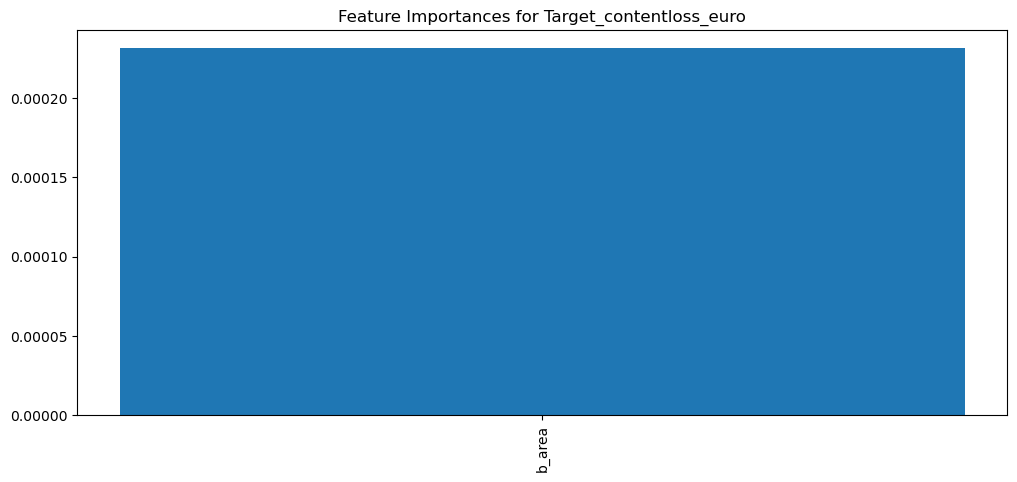

In [17]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12,5))

## coef of feature importances
df_importance = pd.DataFrame({
    "name" : X_unscaled.columns.to_list(),
    "importances" : np.absolute(elastic_net_eval.coef_),
     }) 

# drop features which dont reduce the loss
df_importance = df_importance.loc[df_importance.importances > 0.000, : ] 
df_importance = df_importance.sort_values("importances", ascending=False)

plt.bar(df_importance.name, df_importance.importances)
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

In [54]:
# coef = pd.Series(elastic_net.coef_, index = X_train.columns)
# important_features = pd.concat([coef.sort_values().head(10),
#                      coef.sort_values().tail(10)])
# important_features.plot(kind = "barh")
# plt.title("Coefficients in the ElasticNet Model")

### Plot optimal number of features

In [ ]:
elastic_net_eval.c

In [18]:
# cv results
cv_results = pd.DataFrame(elastic_net_eval.cv_results_)
cv_results


AttributeError: 'ElasticNet' object has no attribute 'cv_results_'

In [ ]:

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')